In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
# for evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/combined_expression.csv")
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,2,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,1,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,1,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,1,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,1,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.shape

(541, 16384)

In [4]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))
len(selected_genes)

300

In [5]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [6]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

    return fig

# 1 Hidden Layer

In [14]:
def hidden1(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 1 hidden layer
    model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model1 = KerasClassifier(build_fn=hidden1, epochs=25, batch_size=16)

In [16]:
history1 = model1.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred1 = model1.predict(X_test)

Train on 564 samples, validate on 109 samples
Epoch 1/25
564/564 [==============================] - 1s 2ms/sample - loss: 0.6777 - accuracy: 0.7482 - val_loss: 0.6305 - val_accuracy: 0.8899
Epoch 2/25
564/564 [==============================] - 0s 330us/sample - loss: 0.5843 - accuracy: 0.8050 - val_loss: 0.5930 - val_accuracy: 0.8991
Epoch 3/25
564/564 [==============================] - 0s 332us/sample - loss: 0.5455 - accuracy: 0.8262 - val_loss: 0.5478 - val_accuracy: 0.9083
Epoch 4/25
564/564 [==============================] - 0s 330us/sample - loss: 0.5244 - accuracy: 0.8191 - val_loss: 0.5188 - val_accuracy: 0.8991
Epoch 5/25
564/564 [==============================] - 0s 325us/sample - loss: 0.5136 - accuracy: 0.8422 - val_loss: 0.4924 - val_accuracy: 0.9083
Epoch 6/25
564/564 [==============================] - 0s 326us/sample - loss: 0.5040 - accuracy: 0.8546 - val_loss: 0.4866 - val_accuracy: 0.8991
Epoch 7/25
564/564 [==============================] - 0s 325us/sample - loss: 0.

In [17]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92        70
           1       0.87      0.85      0.86        39

    accuracy                           0.90       109
   macro avg       0.89      0.89      0.89       109
weighted avg       0.90      0.90      0.90       109



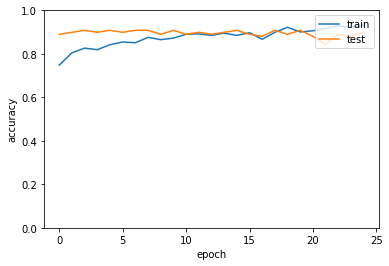

In [18]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

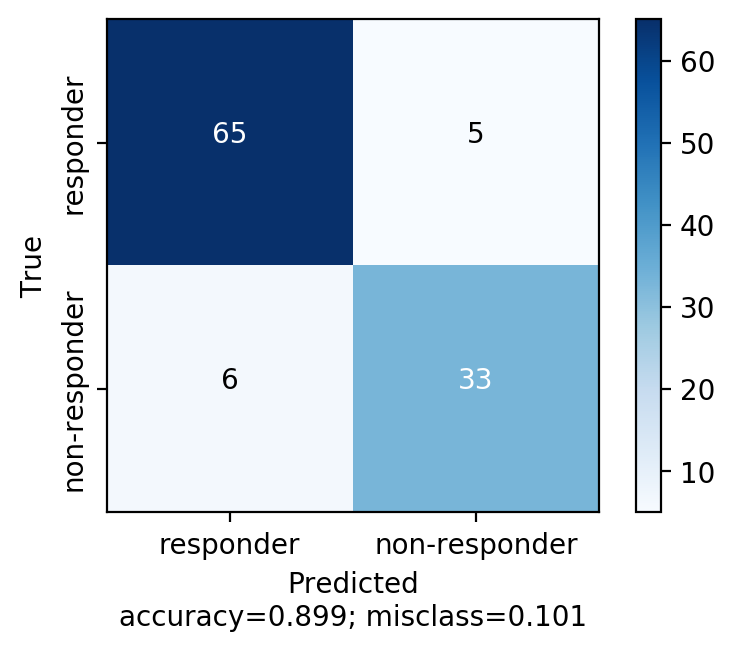

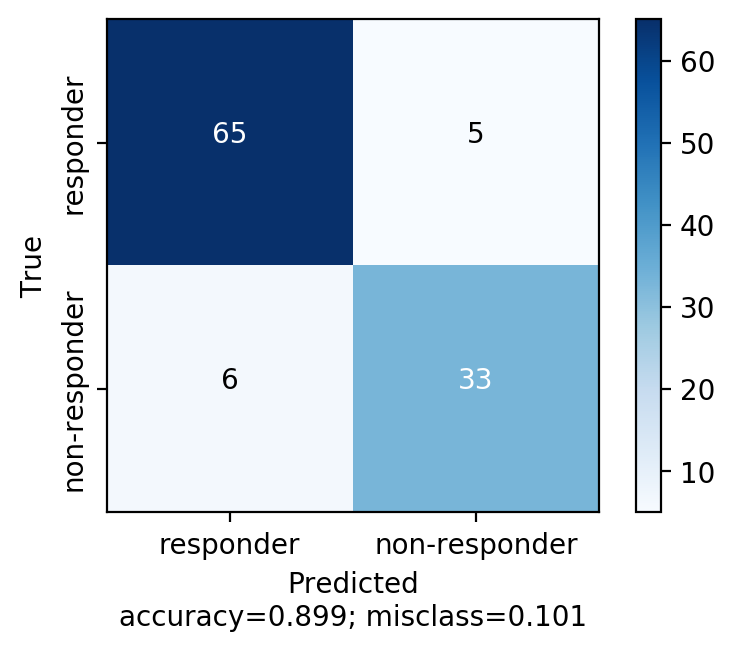

In [19]:
cm = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm, ['responder', 'non-responder'], title='', normalize=False)

In [20]:
model1.model.save('models/')

INFO:tensorflow:Assets written to: models/assets


# 5 Hidden Layers

In [7]:
def hidden5(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 5 hidden layers
    for i in range(5):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model5 = KerasClassifier(build_fn=hidden5, epochs=25, batch_size=16)

In [9]:
history5 = model5.fit(X_train, y_train, validation_data=(X_test,y_test), shuffle=True)
y_pred5 = model5.predict(X_test)

Train on 564 samples, validate on 109 samples
Epoch 1/25
564/564 [==============================] - 4s 7ms/sample - loss: 1.2639 - accuracy: 0.6560 - val_loss: 1.1630 - val_accuracy: 0.8532
Epoch 2/25
564/564 [==============================] - 0s 797us/sample - loss: 1.1445 - accuracy: 0.7163 - val_loss: 1.0962 - val_accuracy: 0.8991
Epoch 3/25
564/564 [==============================] - 0s 797us/sample - loss: 1.0671 - accuracy: 0.7624 - val_loss: 1.0172 - val_accuracy: 0.8716
Epoch 4/25
564/564 [==============================] - 0s 790us/sample - loss: 1.0863 - accuracy: 0.7589 - val_loss: 0.9762 - val_accuracy: 0.8899
Epoch 5/25
564/564 [==============================] - 0s 791us/sample - loss: 1.0739 - accuracy: 0.7730 - val_loss: 0.9519 - val_accuracy: 0.8807
Epoch 6/25
564/564 [==============================] - 0s 789us/sample - loss: 1.0612 - accuracy: 0.7766 - val_loss: 0.9365 - val_accuracy: 0.8716
Epoch 7/25
564/564 [==============================] - 0s 797us/sample - loss: 1.

In [10]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83        70
           1       0.67      0.92      0.77        39

    accuracy                           0.81       109
   macro avg       0.81      0.83      0.80       109
weighted avg       0.85      0.81      0.81       109



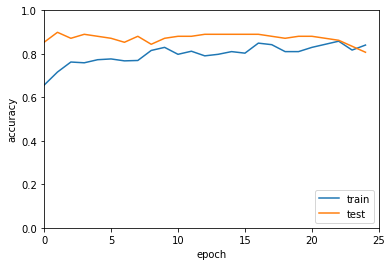

In [32]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

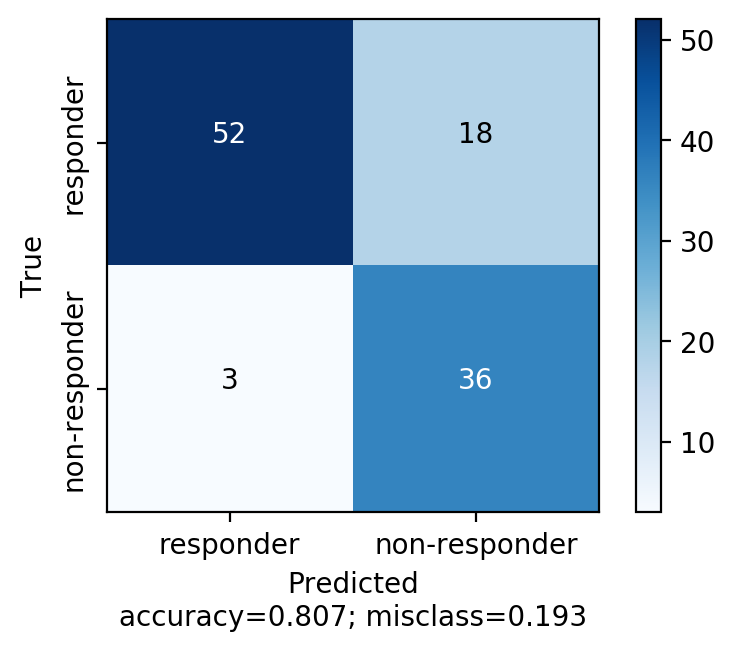

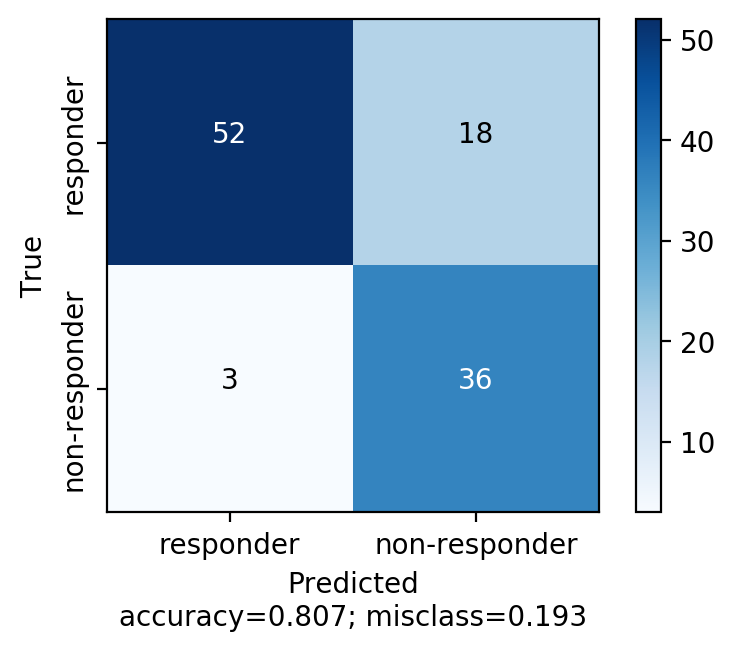

In [12]:
cm = confusion_matrix(y_test, y_pred5)
plt.rcParams.update({'font.size': 10})
plot_confusion_matrix(cm, ['responder', 'non-responder'], title='', normalize=False)

In [13]:
model5.model.save('models/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/assets


# 10 Hidden Layers

In [7]:
def hidden10(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 10 hidden layers
    for i in range(10):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model10 = KerasClassifier(build_fn=hidden10, epochs=25, batch_size=16)

In [9]:
history10 = model10.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=True)
y_pred10 = model10.predict(X_test)

Train on 572 samples, validate on 109 samples
Epoch 1/25
572/572 [==============================] - 10s 17ms/sample - loss: 1.9638 - accuracy: 0.4895 - val_loss: 1.7466 - val_accuracy: 0.5596
Epoch 2/25
572/572 [==============================] - 1s 2ms/sample - loss: 1.8696 - accuracy: 0.5524 - val_loss: 1.7207 - val_accuracy: 0.8624
Epoch 3/25
572/572 [==============================] - 1s 2ms/sample - loss: 1.8212 - accuracy: 0.6031 - val_loss: 1.6915 - val_accuracy: 0.8349
Epoch 4/25
572/572 [==============================] - 1s 2ms/sample - loss: 1.7105 - accuracy: 0.6399 - val_loss: 1.6217 - val_accuracy: 0.7064
Epoch 5/25
572/572 [==============================] - 1s 2ms/sample - loss: 1.7286 - accuracy: 0.6556 - val_loss: 1.5647 - val_accuracy: 0.9083
Epoch 6/25
572/572 [==============================] - 1s 2ms/sample - loss: 1.6876 - accuracy: 0.6888 - val_loss: 1.4645 - val_accuracy: 0.9083
Epoch 7/25
572/572 [==============================] - 1s 2ms/sample - loss: 1.6390 - acc

In [10]:
print(classification_report(y_test, y_pred10))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        66
           1       0.88      0.88      0.88        43

    accuracy                           0.91       109
   macro avg       0.90      0.90      0.90       109
weighted avg       0.91      0.91      0.91       109



In [11]:
print(confusion_matrix(y_test, y_pred10))

[[61  5]
 [ 5 38]]


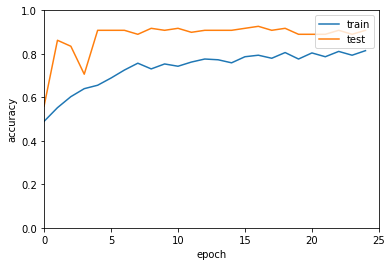

In [12]:
plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.show()

In [21]:
model10.model.save('models/')

INFO:tensorflow:Assets written to: models/assets
